# エッジ検出(CANNY)と教師なし学習(IsolationForest)による簡易物体検出

# TL;DR

OpenCVの処理だけで簡易的に物体検出する。

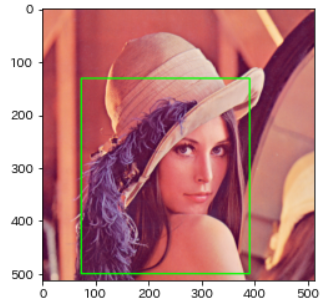

検出にあたり、検出したい物体は輪郭線・エッジが密、背景は疎になっていることを利用して、教師なし学習で物体・背景を分離する。

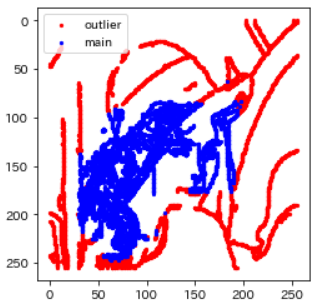



# 初期化

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from PIL import Image
from pathlib import Path
import albumentations as A
import cv2
import numpy as np
import matplotlib.pyplot as plt 
from scipy.sparse import csr_matrix


In [73]:
import japanize_matplotlib
japanize_matplotlib.japanize()


# 📁画像読み込み

In [4]:
!wget http://www.ess.ic.kanagawa-it.ac.jp/std_img/colorimage/lena_std.bmp
img = cv2.imread('lena_std.bmp')

--2022-08-07 02:54:55--  http://www.ess.ic.kanagawa-it.ac.jp/std_img/colorimage/lena_std.bmp
Resolving www.ess.ic.kanagawa-it.ac.jp (www.ess.ic.kanagawa-it.ac.jp)... 202.250.66.20
Connecting to www.ess.ic.kanagawa-it.ac.jp (www.ess.ic.kanagawa-it.ac.jp)|202.250.66.20|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 786486 (768K) [image/bmp]
Saving to: ‘lena_std.bmp.3’

lena_std.bmp.3      100%[===================>] 768.05K  3.43MB/s    in 0.2s    

2022-08-07 02:54:55 (3.43 MB/s) - ‘lena_std.bmp.3’ saved [786486/786486]



In [6]:
%%time
img = cv2.resize(img, (256,256))
img.shape

CPU times: user 227 µs, sys: 348 µs, total: 575 µs
Wall time: 344 µs


(256, 256, 3)

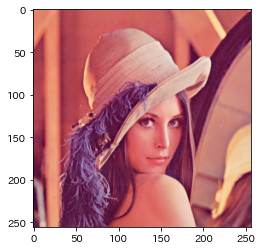

In [7]:
plt.imshow(img[:,:,[2,1,0]])

画像のグレースケール化

In [8]:
%%time
img_gray = cv2.cvtColor(np.array(img),cv2.COLOR_RGB2GRAY) 

CPU times: user 88 µs, sys: 126 µs, total: 214 µs
Wall time: 163 µs


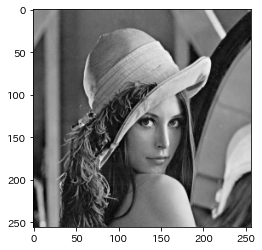

In [9]:
plt.imshow(img_gray, cmap='gray')

# エッジ検出

## Canny

1. 平滑化によりノイズを除去（Gaussianフィルターを使用）
1. 画像の微分によりエッジ検出（Sobelフィルターを使用）
1. 極大値を検出し、エッジ以外を取り除く
1. 2段階の閾値処理

OpenCVで画像のエッジ検出をしてみた - Qiita
https://qiita.com/shoku-pan/items/328edcde833307b164f4


In [10]:
%%time
th1, th2 = 100, 200
img_canny = cv2.Canny(np.array(img_gray),  th1,th2)

CPU times: user 36.1 ms, sys: 0 ns, total: 36.1 ms
Wall time: 3.61 ms


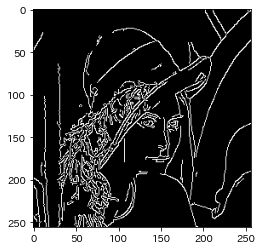

In [11]:
plt.imshow(img_canny, cmap='gray')

# エッジ画像から輪郭線のリストを抽出

In [12]:
contours, _ = cv2.findContours(img_canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

In [13]:
len(contours), contours[5]

(181,
 array([[[ 77, 243]],
 
        [[ 77, 244]],
 
        [[ 77, 245]],
 
        [[ 76, 246]],
 
        [[ 76, 247]],
 
        [[ 77, 248]],
 
        [[ 77, 249]],
 
        [[ 78, 250]],
 
        [[ 79, 251]],
 
        [[ 79, 252]],
 
        [[ 79, 253]],
 
        [[ 80, 254]],
 
        [[ 80, 255]],
 
        [[ 80, 254]],
 
        [[ 80, 253]],
 
        [[ 79, 252]],
 
        [[ 79, 251]],
 
        [[ 79, 250]],
 
        [[ 78, 249]],
 
        [[ 77, 248]],
 
        [[ 76, 247]],
 
        [[ 76, 246]],
 
        [[ 77, 245]],
 
        [[ 77, 244]]], dtype=int32))

# 輪郭線のリストを点群に変換

In [14]:
points = np.concatenate([x.reshape(-1,2) for x in contours], axis=0)

In [15]:
points.shape, points

((9624, 2),
 array([[ 83, 255],
        [ 63, 253],
        [ 76, 251],
        ...,
        [202,   3],
        [202,   2],
        [202,   1]], dtype=int32))

# 輪郭点から外れ値除去（IsolationForest)

外れ値を抽出

In [16]:
contamination=0.4   # 外れ値の割合(0~0.5)

In [17]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(
    contamination=contamination, # 異常値の割合
    max_features=2, random_state=42
)

clf.fit(points)
y_pred = clf.predict(points)

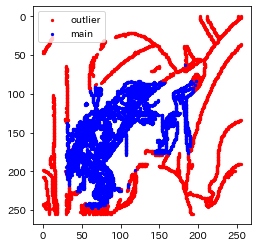

In [18]:
plt.scatter(
    points[y_pred == -1, 0],
    points[y_pred == -1, 1],
    c='r', s=5,
    label='outlier'
)
plt.scatter(
    points[y_pred == 1, 0],
    points[y_pred == 1, 1],
    c='b', s=5,
    label='main',
)
plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis()
plt.show()

# 外れ値を除いた領域を残す

In [19]:
points_normal = points[y_pred==1, :]

# 座標を求める
x,y,w,h = cv2.boundingRect(points_normal)


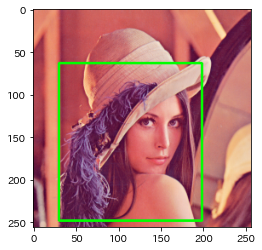

In [20]:
img_detected = cv2.rectangle(np.array(img),(x,y),(x+w,y+h),(0,255,0),2)
plt.imshow(img_detected[:,:,[2,1,0]])

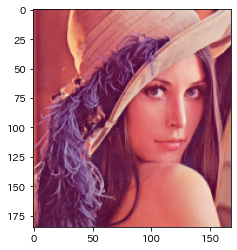

In [21]:
img_croped = img[y:y+h,x:x+w,:]
plt.imshow(img_croped[:,:,[2,1,0]])

# まとめ（関数に）

※画像はPIL Image

In [57]:
img = Image.open('lena_std.bmp')

# 前処理関数

In [68]:
#export
CANNY_THRESH_1 = 100
CANNY_THRESH_2 = 200
CONTAMI_RATIO=0.4
IMSIZE_FIND = 256  # 物体検出作業時の画像サイズ。巨大な画像の物体検出時に計算量を下げるため。
MARGIN = 0.05  # BOUNDING BOXの外周のマージン

def find_crop_point(img:Image)->(float,float,float,float):
    "物体を切り抜くxywhを求める"
    # 輪郭の抽出    
    gray = cv2.cvtColor(np.array(img),cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, CANNY_THRESH_1, CANNY_THRESH_2)
    edges = cv2.dilate(edges, None)
    edges = cv2.erode(edges, None)
    contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

    # 輪郭線のタプルを点群に変換
    # tuple(ndarray(no, none, xy)) -> ndarray(point_no, (x,y))
    points = np.concatenate([x.reshape(-1,2) for x in contours], axis=0)

    # 異常値の除去
    clf = IsolationForest(
        contamination=CONTAMI_RATIO, # 異常値の割合
        max_features=2, random_state=42
    )
    clf.fit(points)
    y_pred = clf.predict(points)
    points_normal = points[y_pred==1, :]

    # 座標を求める
    x,y,w,h = cv2.boundingRect(points_normal)
    # from IPython.core.debugger import Pdb; Pdb().set_trace()
    return x,y,w,h

## 切り抜き箇所の確認

In [69]:
#export
def draw_crop_rect(img:Image):
    x,y,w,h = find_crop_point(img)
    return cv2.rectangle(np.array(img),(x,y),(x+w,y+h),(0,255,0),2)

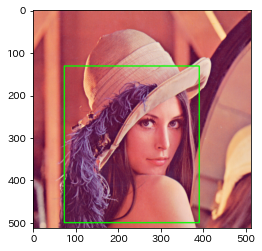

In [70]:
plt.imshow(draw_crop_rect(img))

## 切り抜き関数

In [71]:
#export
def crop_find(img:Image)->Image:
    """ 元サイズ画像を、物体検出して切り抜き    
    1. 元画像(3024x4032)を、いったん256x256へ変換
    2. boxを計算
    3. 元画像をマージンを持って切り抜き
    """
    tmp = img.resize((IMSIZE_FIND,IMSIZE_FIND))
    # 物体検出
    x,y,w,h = find_crop_point(tmp)
    # left,...,bottomへ変換
    cx, cy = x+w//2, y+h//2  # Center of X
    l2 = int(max(w,h)/2*(1+MARGIN))  # 長辺の半分、ほぼ正方形に切り抜くため。
    l,t,r,b = (max(0,cx-l2),max(0,cy-l2),min(IMSIZE_FIND,cx+l2),min(IMSIZE_FIND,cy+l2))
    # 元画像での座標に変換
    h_original,w_original = img.size
    rx = w_original/IMSIZE_FIND  # 横幅比率
    ry = h_original/IMSIZE_FIND
    return img.crop((int(l*rx), int(t*ry), int(r*rx),int(b*ry)))

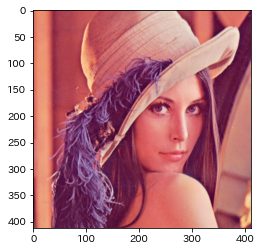

In [72]:
plt.imshow(crop_find(img))

# 備考

## クロージング

「膨張→収縮」処理で、点をつなげる処理。
CANNYの後に、クロージングでエッジを処理してもよいかも。

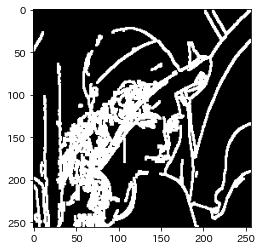

In [30]:
_dilated = cv2.dilate(img_canny, None)
plt.imshow(_dilated, cmap='gray')

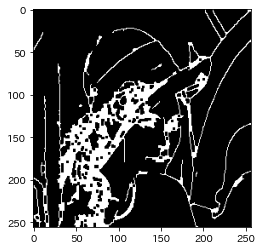

In [31]:
img_closed = cv2.erode(_dilated, None)
plt.imshow(img_closed, cmap='gray')